In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GCN_Cancer-master/GCN_Cancer

Mounted at /content/drive
/content/drive/MyDrive/GCN_Cancer-master/GCN_Cancer


In [ ]:
from tensorflow import compat
tf = compat.v1
#tf.compat.v1.disable_eager_execution()
tf.disable_v2_behavior()
tf.compat.v1.placeholder(dtype=tf.float32)

Instructions for updating:
non-resource variables are not supported in the long term


<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=float32>

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
# !python --version

In [ ]:
!pip install numpy==1.23.1

In [ ]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils
import sklearn.metrics
import sklearn.neighbors
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial.distance
#import tensorflow as tf
import numpy as np
import time
import h5py
import scipy.io as sio

In [ ]:
tf.compat.v1.flags.DEFINE_string('f','','')

In [ ]:
# for name in list(flags.FLAGS):
#      delattr(flags.FLAGS,name)

In [ ]:
#matplotlib inline

flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 1, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 1, 'Number of coarsened graphs.')

In [ ]:
t_start = time.process_time()

In [ ]:
# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

In [ ]:
test = sio.loadmat('Adj_Filtered_List_0Con.mat')
# for Correlaton model
#test = sio.loadmat('C:/Users/RJ\Desktop/exp_fpkm_pancan/processed/CoExpression/Adj_Data/Adj_Spearman_6P.mat')
row = test['row'].astype(np.float32)
col = test['col'].astype(np.float32)
value = test['value'].astype(np.float32)
M, k = row.shape
row = np.array(row)
row = row.reshape(k)
row = row.ravel()
col = np.array(col)
col = col.reshape(k)
col = col.ravel()
value = np.array(value)
value = value.reshape(k)
value = value.ravel()
A = scipy.sparse.coo_matrix((value, (row, col)),shape = (4444,4444))
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=True)
L = [graph.laplacian(A, normalized=True,renormalized=True) for A in graphs]
del test
del A
del row
del col
del value


Layer 0: M_0 = |V| = 7450 nodes (3006 added),|E| = 26686 edges
Layer 1: M_1 = |V| = 3725 nodes (0 added),|E| = 25670 edges


In [ ]:
Data = sio.loadmat('Block_PPIA.mat')
Data1 = Data['Block'][0,0]
Data2 = Data['Block'][0,1]
Data3 = Data['Block'][0,2]
Data4 = Data['Block'][0,3]
Data5 = Data['Block'][0,4]
D1= Data1['D'].astype(np.float32)
D2= Data2['D'].astype(np.float32)
D3= Data3['D'].astype(np.float32)
D4= Data4['D'].astype(np.float32)
D5= Data5['D'].astype(np.float32)
L1= Data1['L'].astype(np.float32)
L2= Data2['L'].astype(np.float32)
L3= Data3['L'].astype(np.float32)
L4= Data4['L'].astype(np.float32)
L5= Data5['L'].astype(np.float32)
# adjust for K-Fold cross validation
Train_Data = np.transpose(np.hstack((D1,D2,D3,D4)))
Val_Data = np.transpose(D5)
Test_Data = np.transpose(D5)
Train_Label = (np.vstack((L1,L2,L3,L4)))
Val_Label = (L5)
Test_Label = (L5)
Test_Label = Test_Label.ravel()
Train_Label = Train_Label.ravel()
Val_Label = Val_Label.ravel()

In [ ]:
Train_Data = coarsening.perm_data(Train_Data, perm)
Val_Data = coarsening.perm_data(Val_Data, perm)
Test_Data = coarsening.perm_data(Test_Data, perm)

In [ ]:
C = 34  # number of classes

common = {}
common['dir_name']       = 'PPI/'
common['num_epochs']     = 20
common['batch_size']     = 200
common['decay_steps']    = 17.7 # * common['num_epochs'] since not used use as in momentum
common['eval_frequency'] = 10 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'apool1'

model_perf = utils.model_perf()

common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = .005
common['decay_rate']     = 0.95
common['momentum']       = 0

common['F']              = [1]
common['K']              = [1]
common['p']              = [2]
common['M']              = [1024,C]


In [ ]:
if True:
    name = 'Run1'
    params = common.copy()
    params['dir_name'] += name
  #  params['filter'] = 'chebyshev5'
    params['filter'] = 'chebyshev2'
    params['brelu'] = 'b1relu'
    model_perf.test(models.cgcnn(L, **params), name, params, Train_Data, Train_Label, Val_Data, Val_Label, Test_Data, Test_Label)
   # model_perf.test(models.cnn2(**params), name, params, Train_Data, Train_Label, Val_Data, Val_Label, Test_Data, Test_Label)

model_perf.show()

if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))


NN architecture
  input: M_0 = 7450
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 7450 * 1 / 2 = 3725
    weights: F_0 * F_1 * K_1 = 1 * 1 * 1 = 1
    biases: F_1 = 1
  layer 2: fc1
    representation: M_2 = 1024
    weights: M_1 * M_2 = 3725 * 1024 = 3814400
    biases: M_2 = 1024
  layer 3: logits (softmax)
    representation: M_3 = 34
    weights: M_2 * M_3 = 1024 * 34 = 34816
    biases: M_3 = 34


/content/drive/MyDrive/GCN_Cancer-master/GCN_Cancer/lib/models.py:937: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  y = tf.layers.max_pooling2d(y, 2, 2, padding='SAME')
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Please use `rate` instead of 

step 200 / 885 (epoch 4.52 / 20):
  learning_rate = 2.84e-03, loss_average = 2.83e-01
  validation accuracy: 91.62 (2034 / 2220), f1 (weighted): 90.93, loss: 4.89e-01
  time: 431s (wall 269s)
step 400 / 885 (epoch 9.04 / 20):
  learning_rate = 1.62e-03, loss_average = 2.14e-01
  validation accuracy: 93.38 (2073 / 2220), f1 (weighted): 92.70, loss: 4.01e-01
  time: 869s (wall 536s)
step 600 / 885 (epoch 13.56 / 20):
  learning_rate = 9.20e-04, loss_average = 1.53e-01
  validation accuracy: 94.05 (2088 / 2220), f1 (weighted): 93.57, loss: 3.75e-01
  time: 1304s (wall 799s)
step 800 / 885 (epoch 18.08 / 20):
  learning_rate = 4.97e-04, loss_average = 1.44e-01
  validation accuracy: 94.01 (2087 / 2220), f1 (weighted): 93.35, loss: 3.55e-01
  time: 1739s (wall 1063s)
step 885 / 885 (epoch 20.00 / 20):
  learning_rate = 4.05e-04, loss_average = 1.46e-01
  validation accuracy: 93.92 (2085 / 2220), f1 (weighted): 93.35, loss: 3.54e-01
  time: 1950s (wall 1191s)
validation accuracy: peak = 94.0

[12. 20. 20. ... 29. 29. 12.]
[12. 20. 20. ... 29. 29. 12.]


<Axes: >

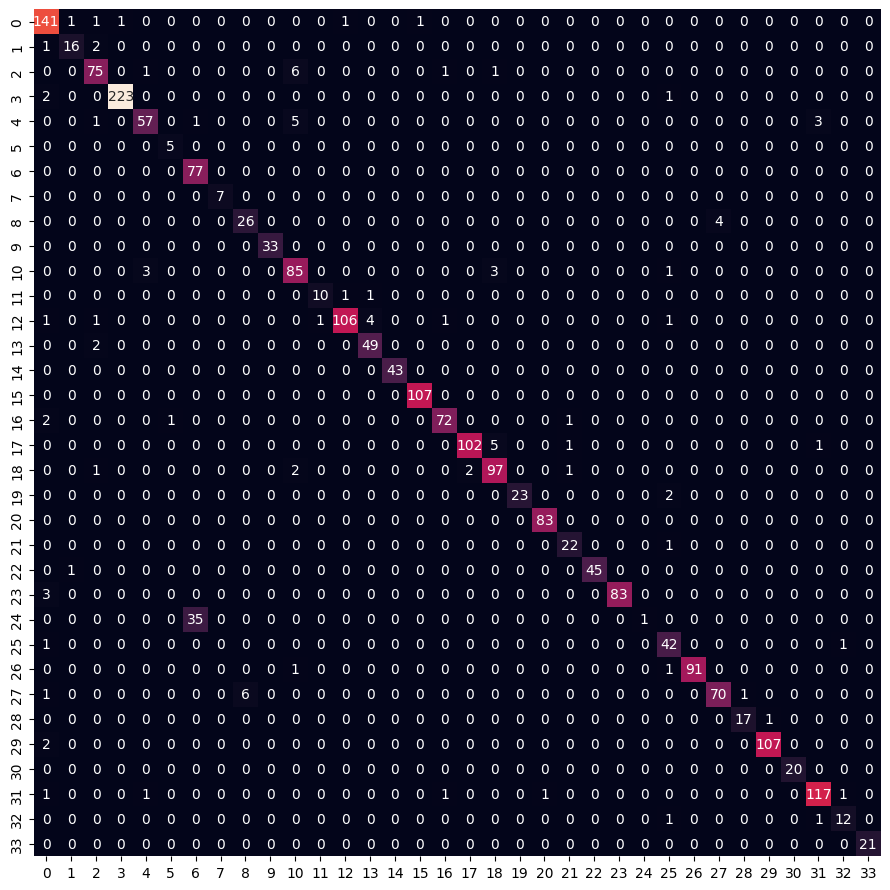

In [ ]:
from sklearn import metrics
import sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial.distance
import numpy as np
import time
import h5py
import scipy.io as sio
from sklearn.metrics import classification_report


predictions = sio.loadmat('Confusion_Val.mat')
labels = sio.loadmat('Confusion_Val_Lab.mat')

p = predictions['predictions'][0]
l = labels['labels'][0]
print(l)
print(p)

c = metrics.confusion_matrix(l,p)

plt.figure(figsize = (11,11))
sn.heatmap(c, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34']
print(classification_report(l, p, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           1     0.9097    0.9658    0.9369       146
           2     0.8889    0.8421    0.8649        19
           3     0.9036    0.8929    0.8982        84
           4     0.9955    0.9867    0.9911       226
           5     0.9194    0.8507    0.8837        67
           6     0.8333    1.0000    0.9091         5
           7     0.6814    1.0000    0.8105        77
           8     1.0000    1.0000    1.0000         7
           9     0.8125    0.8667    0.8387        30
          10     1.0000    1.0000    1.0000        33
          11     0.8586    0.9239    0.8901        92
          12     0.9091    0.8333    0.8696        12
          13     0.9815    0.9217    0.9507       115
          14     0.9074    0.9608    0.9333        51
          15     1.0000    1.0000    1.0000        43
          16     0.9907    1.0000    0.9953       107
          17     0.9600    0.9474    0.9536        76
          18     0.9808    

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Thu Apr 11 03:05:01 2024', '__version__': '1.0', '__globals__': [], 'Train_acc': array([[90.89265537, 93.8079096 , 94.61016949, 95.0960452 , 95.41242938]])}
[90.89265537 93.8079096  94.61016949 95.0960452  95.41242938]


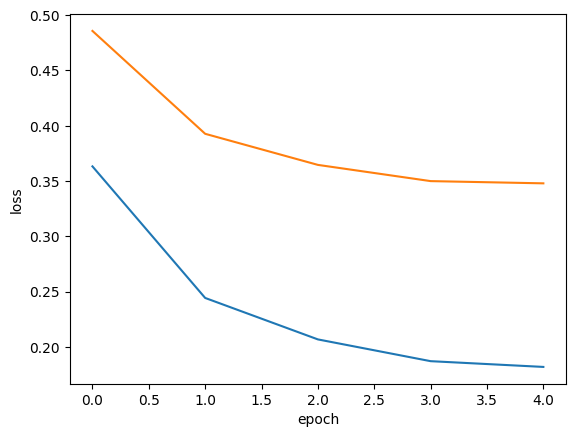

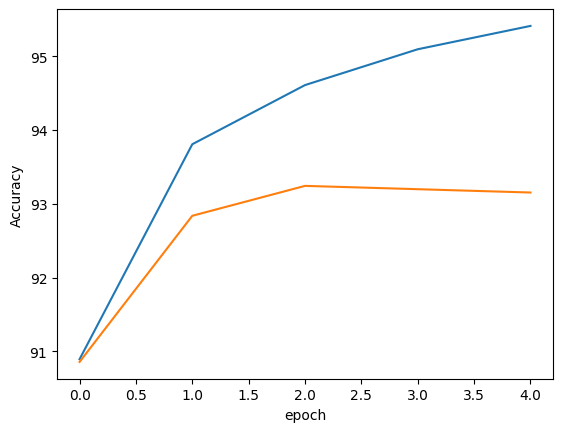

In [ ]:
ta = sio.loadmat('Train_acc.mat')
tl = sio.loadmat('Train_loss.mat')
va = sio.loadmat('Val_acc.mat')
vl = sio.loadmat('Val_loss.mat')
print(ta)
ta = ta['Train_acc'][0]
tl = tl['Train_loss'][0]
va = va['Val_acc'][0]
vl = vl['Val_loss'][0]
print(ta)
plt.plot(np.squeeze(tl))
plt.plot(np.squeeze(vl))
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.title("Loss =" + str(learning_rate))
plt.show()

plt.plot(np.squeeze(ta))
plt.plot(np.squeeze(va))
plt.ylabel('Accuracy')
plt.xlabel('epoch')
#plt.title("Loss =" + str(learning_rate))
plt.show()

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Thu Apr 11 14:22:48 2024', '__version__': '1.0', '__globals__': [], 'Train_acc': array([[72.2259887 , 84.83615819, 87.46892655, 89.10734463, 89.31073446]])}
[72.2259887  84.83615819 87.46892655 89.10734463 89.31073446]


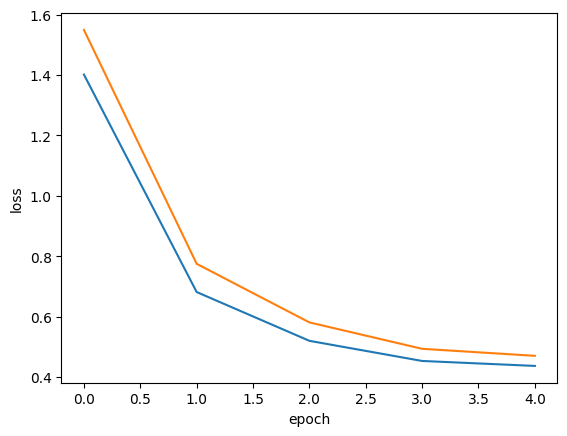

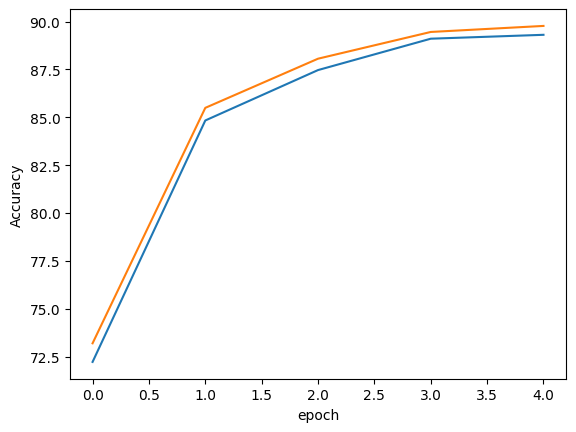

In [ ]:
ta = sio.loadmat('gcn/Train_acc.mat')
tl = sio.loadmat('gcn/Train_loss.mat')
va = sio.loadmat('gcn/Val_acc.mat')
vl = sio.loadmat('gcn/Val_loss.mat')
print(ta)
ta = ta['Train_acc'][0]
tl = tl['Train_loss'][0]
va = va['Val_acc'][0]
vl = vl['Val_loss'][0]
print(ta)
plt.plot(np.squeeze(tl))
plt.plot(np.squeeze(vl))
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.title("Loss =" + str(learning_rate))
plt.show()

plt.plot(np.squeeze(ta))
plt.plot(np.squeeze(va))
plt.ylabel('Accuracy')
plt.xlabel('epoch')
#plt.title("Loss =" + str(learning_rate))
plt.show()

[12. 20. 20. ... 29. 29. 12.]
[12. 20. 20. ... 29. 29. 12.]


<Axes: >

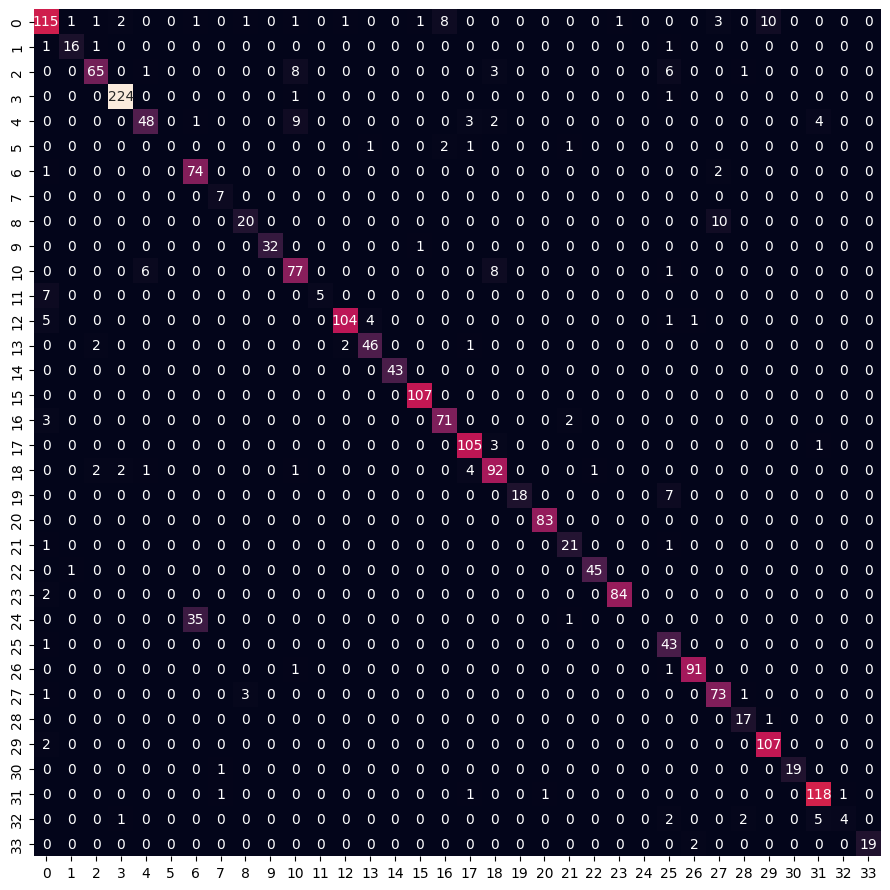

In [ ]:
from sklearn import metrics
import sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial.distance
import numpy as np
import time
import h5py
import scipy.io as sio
from sklearn.metrics import classification_report


predictions = sio.loadmat('gcn/Confusion_Val.mat')
labels = sio.loadmat('gcn/Confusion_Val_Lab.mat')

p = predictions['predictions'][0]
l = labels['labels'][0]
print(l)
print(p)

c = metrics.confusion_matrix(l,p)

plt.figure(figsize = (11,11))
sn.heatmap(c, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34']
print(classification_report(l, p, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           1     0.8273    0.7877    0.8070       146
           2     0.8889    0.8421    0.8649        19
           3     0.9155    0.7738    0.8387        84
           4     0.9782    0.9912    0.9846       226
           5     0.8571    0.7164    0.7805        67
           6     0.0000    0.0000    0.0000         5
           7     0.6667    0.9610    0.7872        77
           8     0.7778    1.0000    0.8750         7
           9     0.8333    0.6667    0.7407        30
          10     1.0000    0.9697    0.9846        33
          11     0.7857    0.8370    0.8105        92
          12     1.0000    0.4167    0.5882        12
          13     0.9720    0.9043    0.9369       115
          14     0.9020    0.9020    0.9020        51
          15     1.0000    1.0000    1.0000        43
          16     0.9817    1.0000    0.9907       107
          17     0.8765    0.9342    0.9045        76
          18     0.9130    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
